In [2]:
import torch
print(f'torch verison: {torch.__version__}')
import numpy
print(f'numpy version: {numpy.__version__}')
print(f'MPS backend: {torch.backends.mps.is_available()}')

import time

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Simple matrix multiplication test
x = torch.rand(1000, 1000).to(device)
y = torch.rand(1000, 1000).to(device)

start = time.time()
z = torch.matmul(x, y)
print(f"Matrix multiplication took {time.time() - start:.4f} seconds")

torch verison: 2.5.1
numpy version: 2.2.3
MPS backend: True
Using device: mps
Matrix multiplication took 0.1227 seconds


In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'Temperature (°Celsius)')

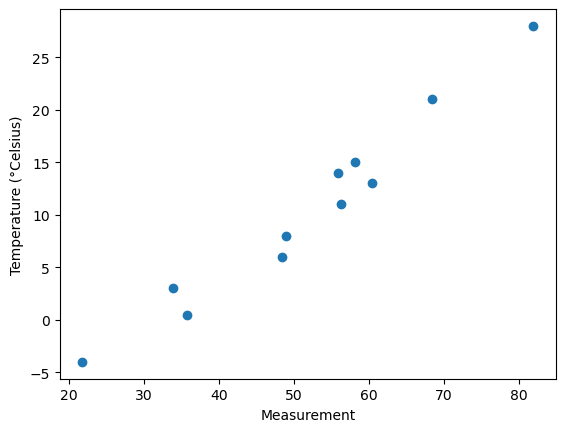

In [12]:
import matplotlib.pyplot as plt

plt.scatter(t_u, t_c)
plt.xlabel('Measurement')
plt.ylabel('Temperature (°Celsius)')

In [13]:
def model(t_u, w, b):
    return w * t_u + b

In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [72]:
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [73]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [82]:
delta = 0.001
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) -
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [83]:
learning_rate = 1e-3
w = w - learning_rate * loss_rate_of_change_w

In [84]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [85]:
t_p = model(t_u, w, b)
t_p

tensor([-3156.7336, -4947.1113, -5150.9663, -7251.5581, -4982.5645, -4326.6836,
        -2997.1951, -1924.7407, -4282.3672, -5345.9580, -6055.0186])

In [21]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [22]:
def dmodel_dw(t_u, w, b):
    return t_u

In [23]:
def dmodel_db(t_u, w, b):
    return 1.0

In [24]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [94]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        print(f'    Params: {params}')
        print(f'    Grad:   {grad}')

    return params    

In [95]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
Epoch 4, Loss 64915905708032.000000
    Params: tensor([8589999.0000,  151310.8906])
    Grad:   tensor([-8.7385e+08, -1.5393e+07])
Epoch 5, Loss 217130525461053440.000000
    Params: tensor([-4.9680e+08, -8.7510e+06])
    Grad:   tensor([5.0539e+10, 8.9023e+08])
Epoch 6, Loss 726257583152928129024.000000
    Params: tensor([2.8732e+10, 5.0610e+08])
    Grad:   tensor([-2.9229e+12, -5.1486e+10])
Epoch 7, Loss 2429183416467662896627712.000000
    Params: tensor([-1.6617e+12, -2.9270e+10])
    Grad:   tensor([1.6904e+14, 2.9776e+12])
Epoch 8, Loss 8125122549611731432050262016.000000
    Params: tensor([9.6102e+13, 1.6928e+12])
   

tensor([nan, nan])

In [96]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
Epoch 4, Loss 37.552845
    Params: tensor([ 0.2543, -0.0143])
    Grad:   tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540283
    Params: tensor([ 0.2413, -0.0149])
    Grad:   tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351154
    Params: tensor([ 0.2360, -0.0153])
    Grad:   tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148884
    Params: tensor([ 0.2338, -0.0156])
    Grad:   tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113848
    Params: tensor([ 0.2329, -0.0159])
    Grad:   tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
    Params: tensor([ 0.2325, -0.0162])
    Grad:   tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    G

tensor([ 0.2327, -0.0438])

In [97]:
t_un = 0.1 * t_u

In [102]:
params = training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

params

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
    Params: tensor([2.2616, 0.1004])
    Grad:   tensor([-5.2218,  2.1327])
Epoch 5, Loss 29.507153
    Params: tensor([2.2853, 0.0740])
    Grad:   tensor([-2.3715,  2.6310])
Epoch 6, Loss 29.392456
    Params: tensor([2.2978, 0.0458])
    Grad:   tensor([-1.2492,  2.8241])
Epoch 7, Loss 29.298828
    Params: tensor([2.3059, 0.0168])
    Grad:   tensor([-0.8071,  2.8970])
Epoch 8, Loss 29.208717
    Params: tensor([ 2.3122, -0.0124])
    Grad:   tensor([-0.6325,  2.9227])
Epoch 9, Loss 29.119415
    Params: tensor([ 2.3178, -0.0417])
    Grad:   tensor([-0.5633,  2.9298])
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.535

tensor([ 2.7553, -2.5162])

In [105]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

params

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
    Params: tensor([2.2616, 0.1004])
    Grad:   tensor([-5.2218,  2.1327])
Epoch 5, Loss 29.507153
    Params: tensor([2.2853, 0.0740])
    Grad:   tensor([-2.3715,  2.6310])
Epoch 6, Loss 29.392456
    Params: tensor([2.2978, 0.0458])
    Grad:   tensor([-1.2492,  2.8241])
Epoch 7, Loss 29.298828
    Params: tensor([2.3059, 0.0168])
    Grad:   tensor([-0.8071,  2.8970])
Epoch 8, Loss 29.208717
    Params: tensor([ 2.3122, -0.0124])
    Grad:   tensor([-0.6325,  2.9227])
Epoch 9, Loss 29.119415
    Params: tensor([ 2.3178, -0.0417])
    Grad:   tensor([-0.5633,  2.9298])
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.535

tensor([  5.3671, -17.3012])

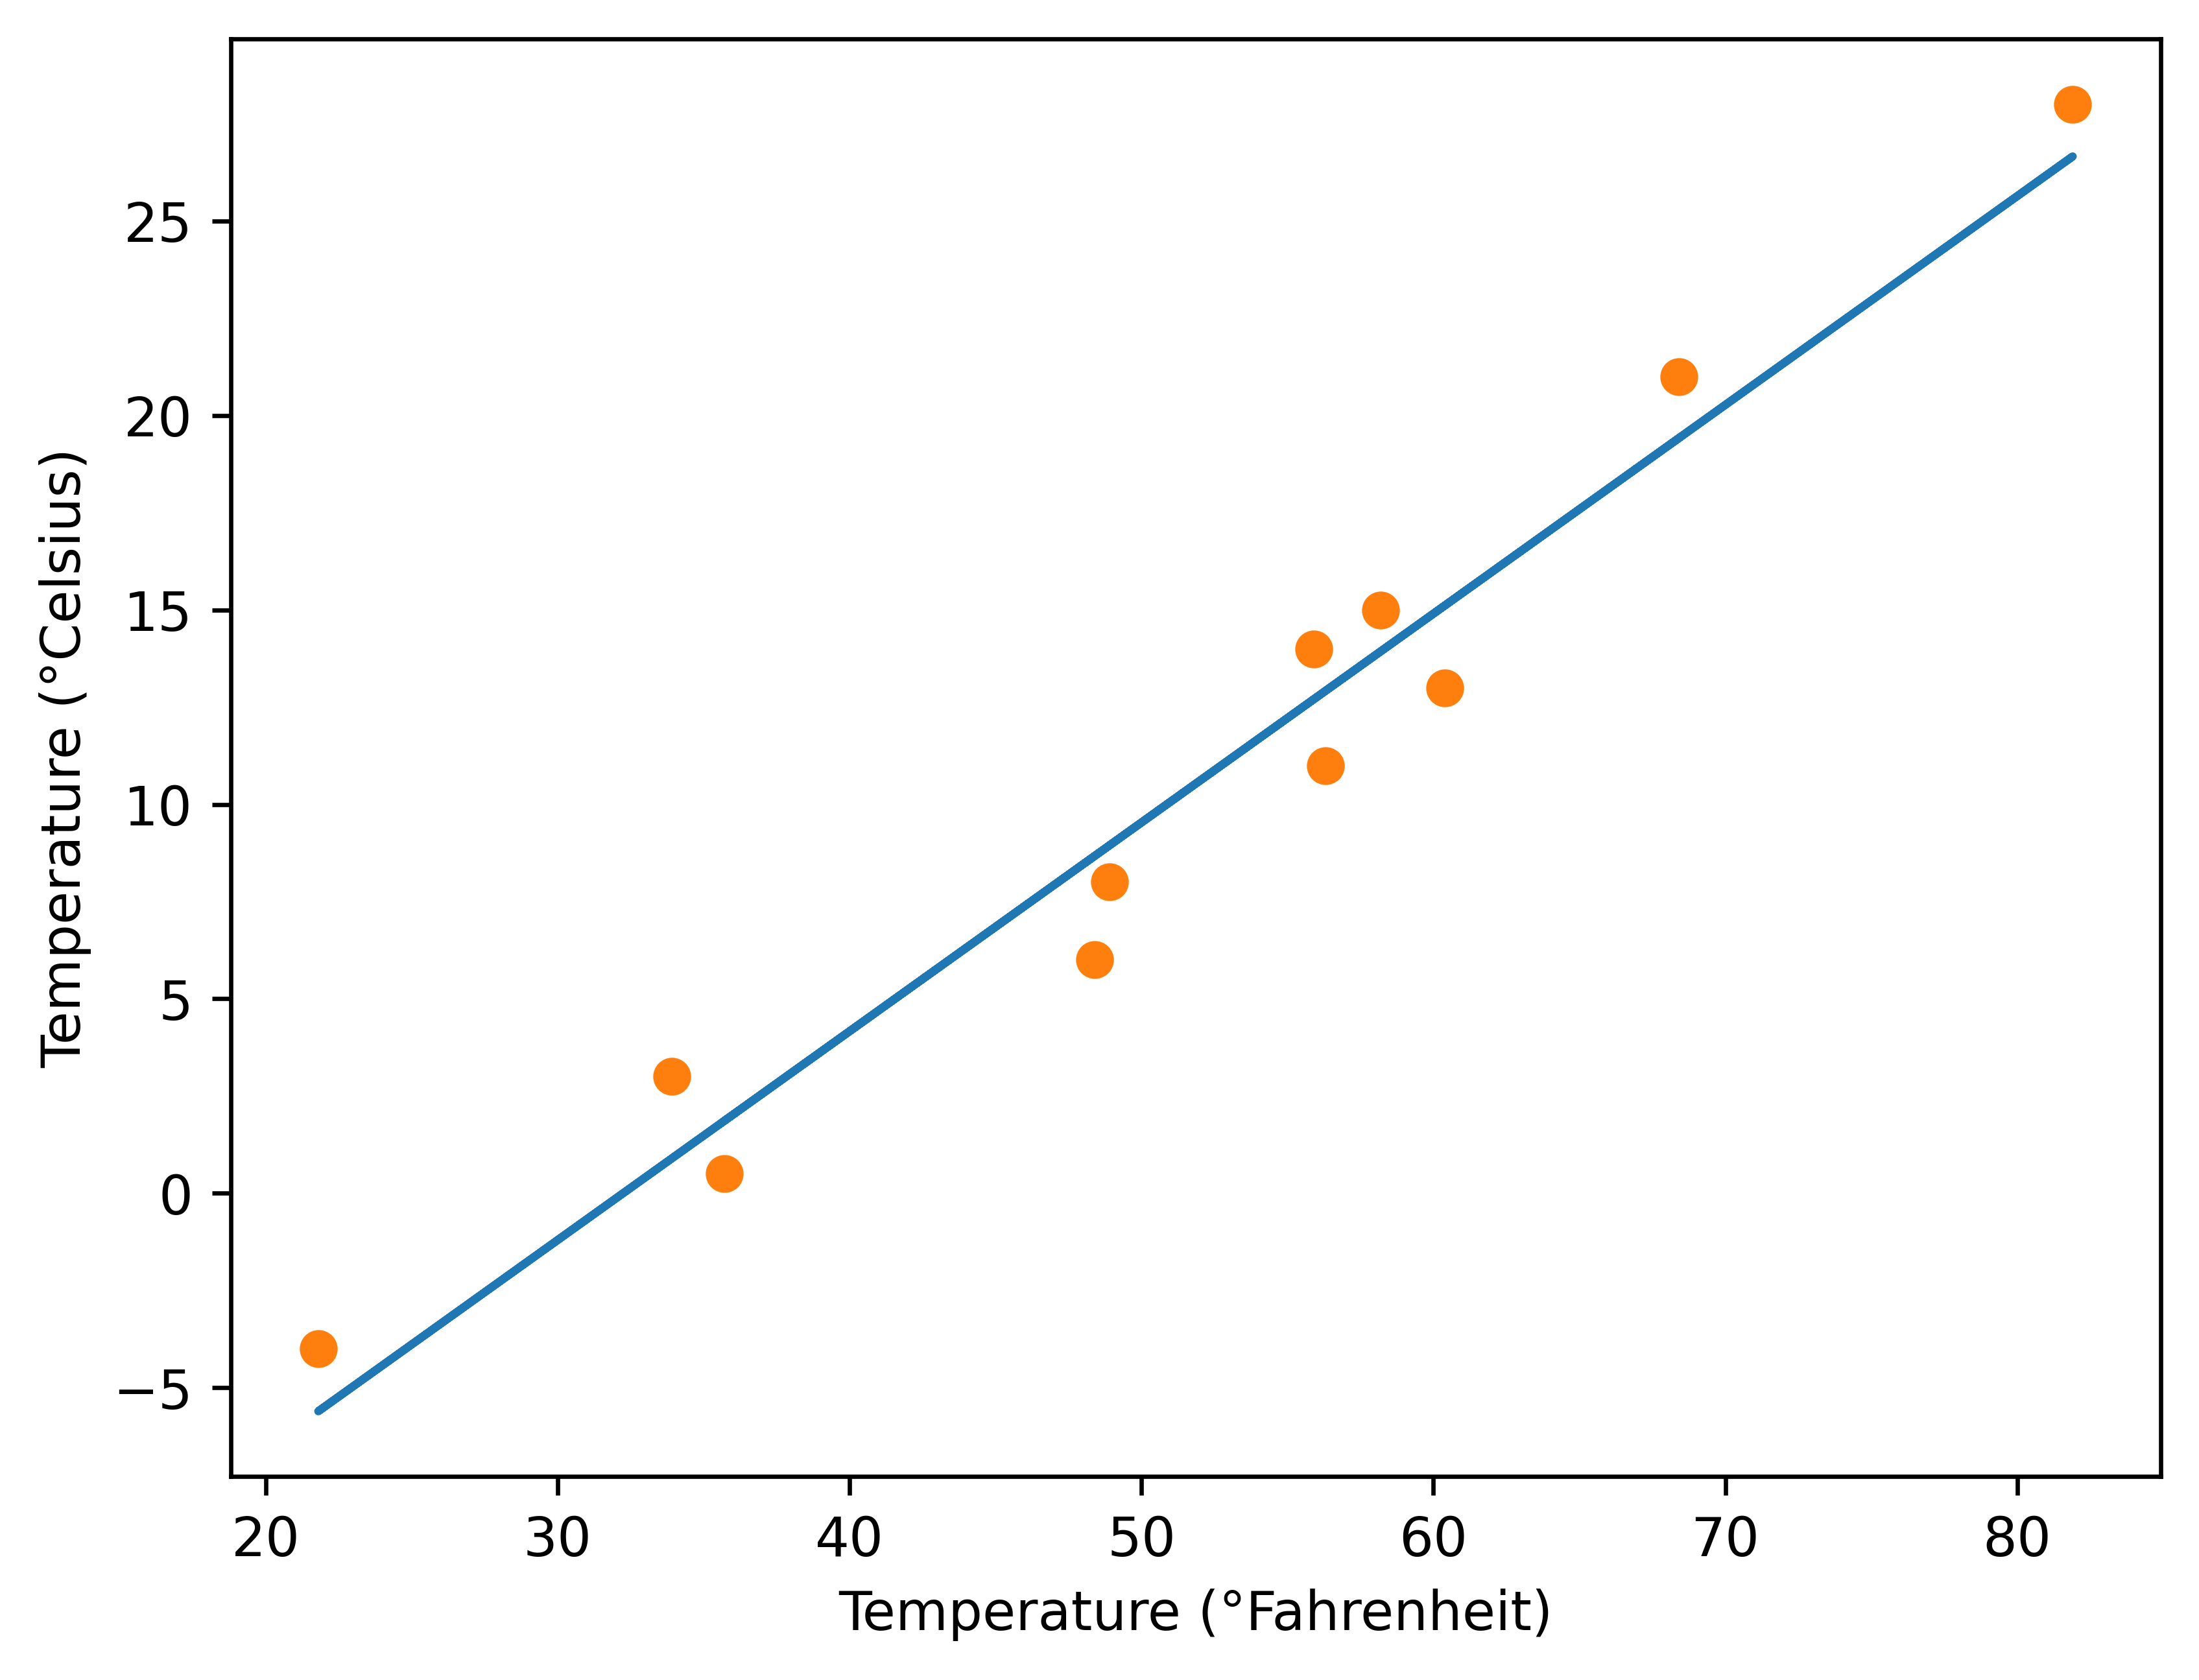

In [106]:
from matplotlib import pyplot as plt
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [108]:
def model(t_u, w, b):
    return w * t_u + b

In [109]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [110]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [111]:
params.grad is None

True

In [112]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

In [113]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [114]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

params

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [115]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_adafactor',
 '_functional',
 'lr_scheduler',
 'swa_utils']

In [116]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

In [119]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [120]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

In [121]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [122]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086698
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

In [127]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 6,  2,  7,  4, 10,  3,  9,  1,  0]), tensor([8, 5]))

In [128]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [129]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [126]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 32.3407, Validation loss 296.4708
Epoch 2, Training loss 21.5723, Validation loss 206.2375
Epoch 3, Training loss 18.6824, Validation loss 166.0221
Epoch 500, Training loss 6.6598, Validation loss 57.5818
Epoch 1000, Training loss 3.6123, Validation loss 31.5658
Epoch 1500, Training loss 2.7763, Validation loss 21.0658
Epoch 2000, Training loss 2.5469, Validation loss 16.4239
Epoch 2500, Training loss 2.4840, Validation loss 14.2279
Epoch 3000, Training loss 2.4668, Validation loss 13.1422


tensor([  4.7232, -14.6063], requires_grad=True)